<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/PDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [3]:
import tensorflow as tf 
from tensorflow import keras
tf.test.gpu_device_name()

# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

'/device:GPU:0'

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import time
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-alpha0


In [0]:
nx = 50
ny = 50

xx = np.linspace(0.01, 2, nx).astype('float32').reshape(nx,1)
yy = np.linspace(0.01, 2, ny).astype('float32').reshape(ny,1)
xv, yv = np.meshgrid(xx, yy)

x = np.stack((xv.reshape(nx * ny), yv.reshape(nx * ny)), axis=-1).reshape(nx * ny, 2)
x = tf.constant(x)

batch_size = 5

In [0]:
def psy_trial(x1, x2, net_out):
    return x2 * tf.math.sin(tf.constant(np.pi) * x1) + x1 * (1 - x1) * x2 * (1 - x2) * net_out

In [0]:
# first time run all, and stop when train 
# second time from here

model = Sequential()
model.add(Dense(10, input_shape=(None, 2),activation='tanh'))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam()

# model.add(Dense(1,kernel_initializer='random_uniform',
#                 bias_initializer='zeros',activation='linear'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, None, 10)          30        
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)

In [22]:
example_batch = next(iter(dataset))
source = example_batch
print("Shapes:", source.shape)

Shapes: (5, 2)


In [23]:
net_out = model(source)
x1 = tf.reshape(source[:,0], [5,1])
x2 = tf.reshape(source[:,1], [5,1])
psy_trial(x1, x2, net_out)

<tf.Tensor: id=6753, shape=(5, 1), dtype=float32, numpy=
array([[0.000314  ],
       [0.00158254],
       [0.00282498],
       [0.00402116],
       [0.00515167]], dtype=float32)>

In [0]:
def loss_function(y_true, y_pred):
    return tf.reduce_sum(keras.losses.mean_squared_error(y_true, y_pred), 0)

In [0]:
x = source
with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        net_out = model(x)
        x1 = tf.reshape(x[:,0], [5,1])
        x2 = tf.reshape(x[:,1], [5,1])

        psy_t = psy_trial(x1, x2, net_out)

    dy_dx = gg.gradient(psy_t, x)
d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient

In [26]:
d2y_dx2[:,1]

<tf.Tensor: id=7012, shape=(5,), dtype=float32, numpy=
array([3.136086 , 3.0901332, 2.9946413, 2.8510664, 2.661653 ],
      dtype=float32)>

In [0]:
@tf.function
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        g_total.watch(x)
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                x1 = tf.reshape(x[:,0], [batch_size,1])
                x2 = tf.reshape(x[:,1], [batch_size,1])
                
                psy_t = psy_trial(x1, x2, net_out)

            dy_dx = gg.gradient(psy_t, x)
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        deltax = tf.reshape(d2y_dx2[:,0], [batch_size,1])
        deltay = tf.reshape(d2y_dx2[:,1], [batch_size,1])

        loss = loss_function(deltax + deltay, tf.constant(np.zeros([batch_size, 1])))
        
        
    grads = g_total.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss, deltax + deltay

In [28]:
train_on_batch(source)

(<tf.Tensor: id=8628, shape=(), dtype=float64, numpy=173.50576860983756>,
 <tf.Tensor: id=8629, shape=(5, 1), dtype=float32, numpy=
 array([[6.2706504],
        [6.173253 ],
        [5.9762907],
        [5.6828556],
        [5.2976184]], dtype=float32)>)

# Train

In [33]:
from keras import backend as K
K.set_session

<function keras.backend.tensorflow_backend.set_session>

In [30]:
for epoch in range(1000):
    for batch, source_data in enumerate(dataset):
        start = time.time()
        loss, s = train_on_batch(source_data)
    
#     if epoch % 10 == 0:
    print("Epoch #%d, Loss %.4f, Time %.2f sec" % (epoch, loss, time.time() - start))
#     print(model(source))

Epoch #0, Loss 172.9591, Time 0.01 sec
Epoch #1, Loss 172.4134, Time 0.01 sec
Epoch #2, Loss 171.8686, Time 0.01 sec
Epoch #3, Loss 171.3247, Time 0.01 sec
Epoch #4, Loss 170.7816, Time 0.01 sec
Epoch #5, Loss 170.2393, Time 0.01 sec
Epoch #6, Loss 169.6977, Time 0.01 sec
Epoch #7, Loss 169.1567, Time 0.01 sec
Epoch #8, Loss 168.6163, Time 0.01 sec
Epoch #9, Loss 168.0764, Time 0.01 sec
Epoch #10, Loss 167.5370, Time 0.01 sec
Epoch #11, Loss 166.9981, Time 0.01 sec
Epoch #12, Loss 166.4597, Time 0.01 sec
Epoch #13, Loss 165.9218, Time 0.01 sec
Epoch #14, Loss 165.3844, Time 0.01 sec
Epoch #15, Loss 164.8475, Time 0.01 sec
Epoch #16, Loss 164.3111, Time 0.01 sec
Epoch #17, Loss 163.7751, Time 0.01 sec
Epoch #18, Loss 163.2396, Time 0.01 sec
Epoch #19, Loss 162.7045, Time 0.01 sec
Epoch #20, Loss 162.1699, Time 0.01 sec
Epoch #21, Loss 161.6356, Time 0.01 sec
Epoch #22, Loss 161.1018, Time 0.01 sec
Epoch #23, Loss 160.5683, Time 0.01 sec
Epoch #24, Loss 160.0352, Time 0.01 sec
Epoch #25,

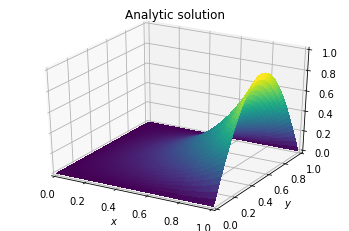

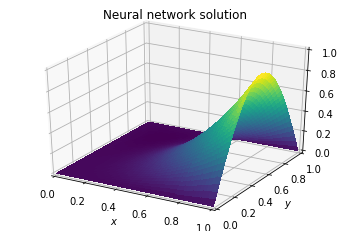

In [34]:
x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)
def analytic_solution(x):
    return (1 / (np.exp(np.pi) - np.exp(-np.pi))) * \
    		np.sin(np.pi * x[0]) * (np.exp(np.pi * x[1]) - np.exp(-np.pi * x[1]))
surface = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface[i][j] = analytic_solution([x, y])
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.title("Analytic solution")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');


x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)
def A(x):
    return x[1] * np.sin(np.pi * x[0])


def psy_trial(x, net_out):
    return A(x) + x[0] * (1 - x[0]) * x[1] * (1 - x[1]) * net_out

surface1 = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface1[i][j] = psy_trial((x,y), model(np.array([x,y]).reshape(1,2))[0][0].numpy())
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface1, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.title("Neural network solution")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [35]:
model(np.array([x,y]).reshape(1,2))

<tf.Tensor: id=66642, shape=(1, 1), dtype=float32, numpy=array([[-6.414961]], dtype=float32)>

In [36]:
for i, x in enumerate(xx):
    for j, y in enumerate(yy):
        print(model(np.array([x,y]).reshape(1,2))[0][0].numpy())

-3.2513332
-3.3822587
-3.509094
-3.631668
-3.7498434
-3.8635163
-3.9726152
-4.0770984
-4.1769524
-4.2721887
-4.362844
-4.448975
-4.5306573
-4.6079836
-4.6810584
-4.75
-4.8149343
-4.875996
-4.933325
-4.9870644
-5.0373607
-5.0843606
-5.1282115
-5.1690598
-5.2070494
-5.242321
-5.2750125
-5.305259
-5.333191
-5.3589325
-5.3826056
-5.4043264
-5.4242053
-5.442349
-5.458859
-5.473831
-5.487358
-5.4995255
-5.5104165
-5.520108
-5.528675
-5.5361853
-5.542706
-5.548298
-5.55302
-5.556926
-5.5600677
-5.562494
-5.564248
-5.565376
-3.3666615
-3.4956532
-3.6204712
-3.7409618
-3.8570032
-3.9685059
-4.0754123
-4.177694
-4.2753487
-4.3684015
-4.456897
-4.540901
-4.620499
-4.6957874
-4.766878
-4.833894
-4.896965
-4.956227
-5.0118237
-5.0638986
-5.1125994
-5.1580734
-5.200466
-5.2399244
-5.27659
-5.3106036
-5.342101
-5.371215
-5.3980737
-5.4228
-5.445513
-5.4663267
-5.48535
-5.5026865
-5.5184345
-5.53269
-5.545541
-5.5570726
-5.567365
-5.5764937
-5.5845313
-5.591544
-5.597597
-5.6027503
-5.6070585
-5.61057